## Convolutional Neural Networks (CNNs) Demo

The following demo uses a cats vs dogs dataset. Start by downloading the dataset and unzipping to your local environment: [https://techx.blob.core.windows.net/cats-and-dogs/dataset.zip](https://techx.blob.core.windows.net/cats-and-dogs/dataset.zip)

### Part I -  Training Custom CNN Model

#### Import Libraries

In [ ]:
%matplotlib inline

from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import activations
from vis.utils import utils
from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

import keras
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

#### Helper Methods

In [2]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['acc'])
    acc = smooth_curve(history.history['acc'][:steps])
    val_acc = smooth_curve(history.history['val_acc'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

#### Load and Prepare Data

In [3]:
# Set paths for datasets
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create image data generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set target_size=(150x150), batch_size=32, class_mode=binary
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Create and Train Model

Create and train a sequential model with the following architecture:
- Convolution layer with 32 filters, 3x3 kernel, relu activation, and padding
- Max pooling layer with a size of 2x2
- Flattening layer
- Densely connected output layer with dimension of 1 and sigmoid activation function

In [4]:
# create the model defined above
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', name='output'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train model for 20 epochs, with 100 steps per epoch, and 50 validation steps
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=20, 
                                      validation_data=validation_generator, validation_steps=50, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 24s 244ms/step - loss: 0.8631 - acc: 0.5550 - val_loss: 0.6511 - val_acc: 0.6225
Epoch 2/20
100/100 [==============================] - 22s 220ms/step - loss: 0.6588 - acc: 0.6075 - val_loss: 0.6303 - val_acc: 0.6450
Epoch 3/20
100/100 [==============================] - 22s 218ms/step - loss: 0.6464 - acc: 0.6225 - val_loss: 0.6338 - val_acc: 0.6091
Epoch 4/20
100/100 [==============================] - 22s 218ms/step - loss: 0.6353 - acc: 0.6466 - val_loss: 0.6130 - val_acc: 0.6656
Epoch 5/20
100/100 [==============================] - 22s 220ms/step - loss: 0.6311 - acc: 0.6431 - val_loss: 0.6113 - val_acc: 0.6536
Epoch 6/20
100/100 [==============================] - 22s 219ms/step - loss: 0.6371 - acc: 0.6459 - val_loss: 0.6075 - val_acc: 0.6798
Epoch 7/20
100/100 [==============================] - 22s 217ms/step -

#### Save Model and Plot Results

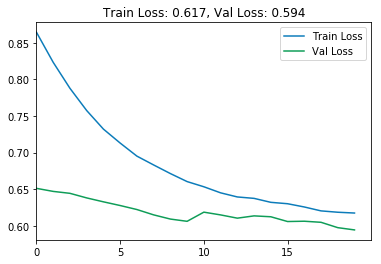

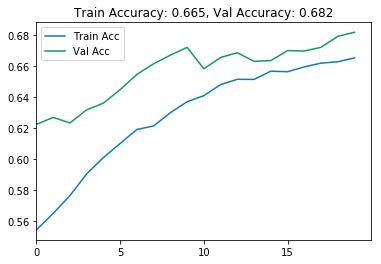

In [5]:
# save the model and its history
model.save('model.h5')
save_history(history, 'history.bin')

# plot results
history = load_history('history.bin')
plot_compare(history)

### Part II - Visualizing Layers Using VGG
For the rest of the demo, we will be using a pretrained VGG model which can be imported through the keras library.

#### Load and Display an Image

(1, 150, 150, 3)


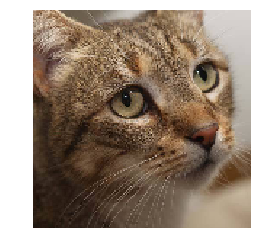

In [6]:
img_path = './dataset/train/cats/cat.54.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

#### Load and Analyze VGG Summary

In [7]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### Output of Convolution Layers

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide


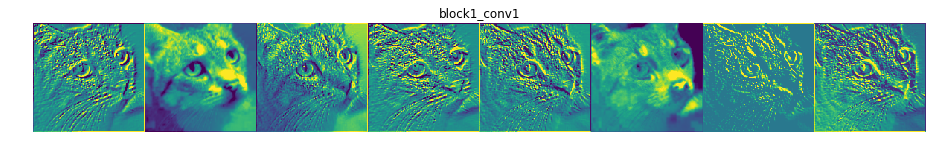

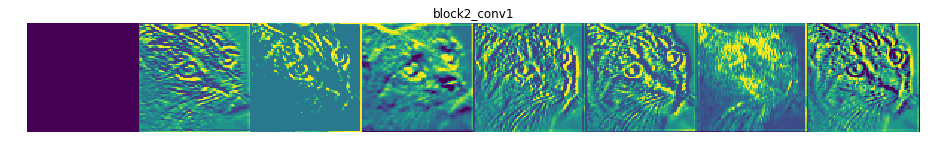

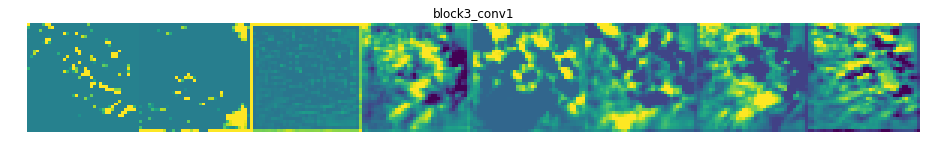

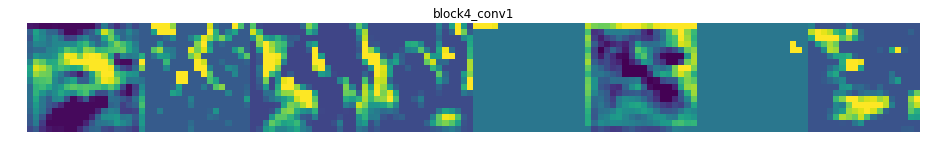

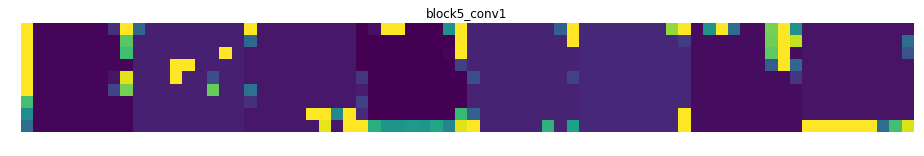

In [8]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

#### Visualize Dense Layers

/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


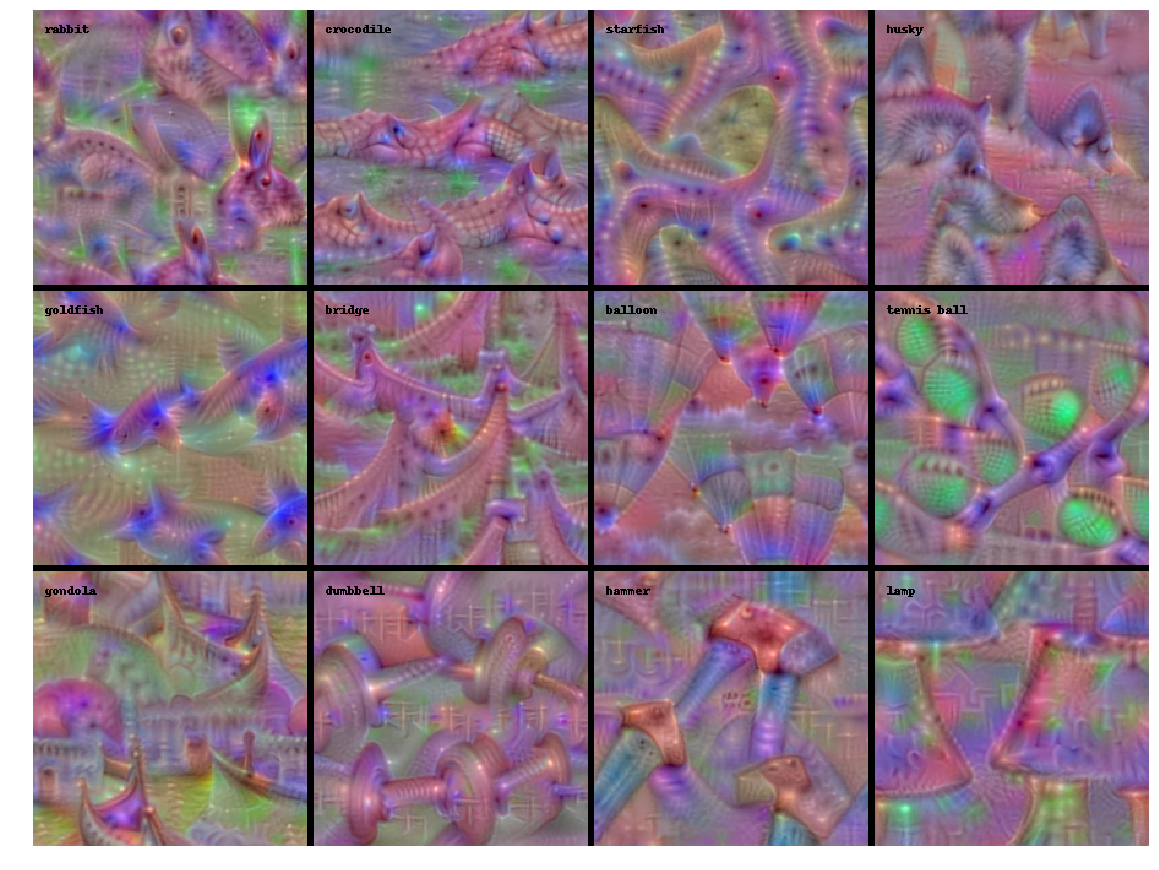

In [9]:
# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# Visualize layers
codes = '''
rabbit 330
crocodile 49
starfish 327
husky 248
goldfish 1
bridge 839
balloon 417
tennis ball 852
gondola 576
dumbbell 543
hammer 587
lamp 846
'''

initial = []
images = []
tuples = []
for line in codes.split('\n'):
    if not line:
        continue
    name, idx = line.rsplit(' ', 1)
    idx = int(idx)
    img = visualize_activation(model, layer_idx, filter_indices=idx, 
                               tv_weight=0., max_iter=300, input_modifiers=[Jitter(16)])

    initial.append(img)
    tuples.append((name, idx))

i = 0
for name, idx in tuples:
    img = visualize_activation(model, layer_idx, filter_indices=idx,
                               seed_input = initial[i], max_iter=300, input_modifiers=[Jitter(16)])
    img = utils.draw_text(img, name)
    i += 1
    images.append(img)

stitched = utils.stitch_images(images, cols=4)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(stitched)
plt.show()

#### Visualize Filters

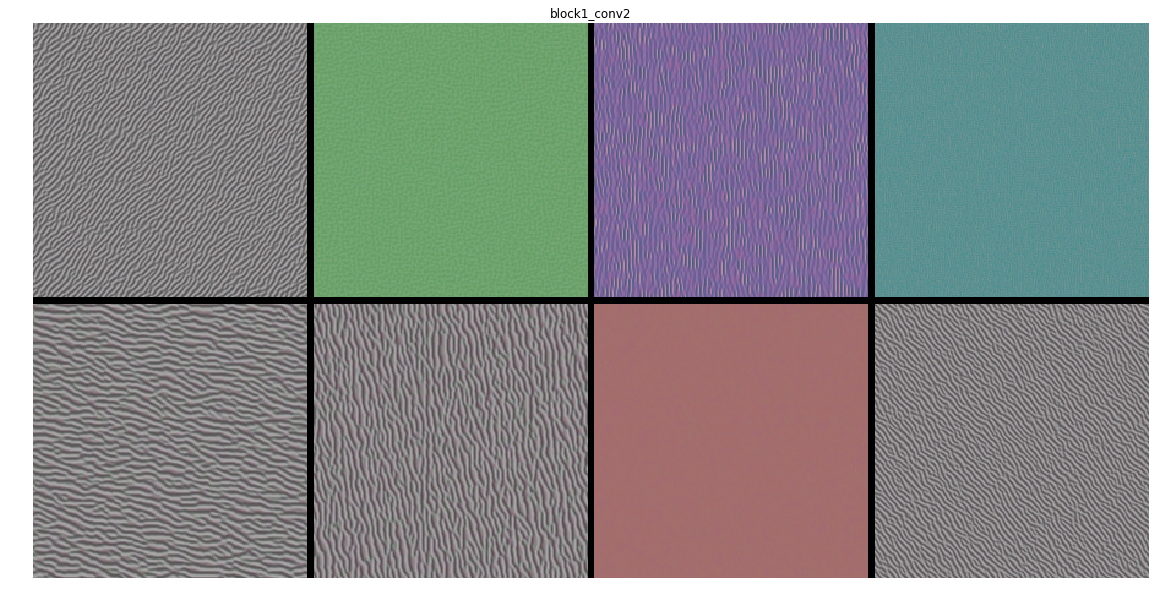

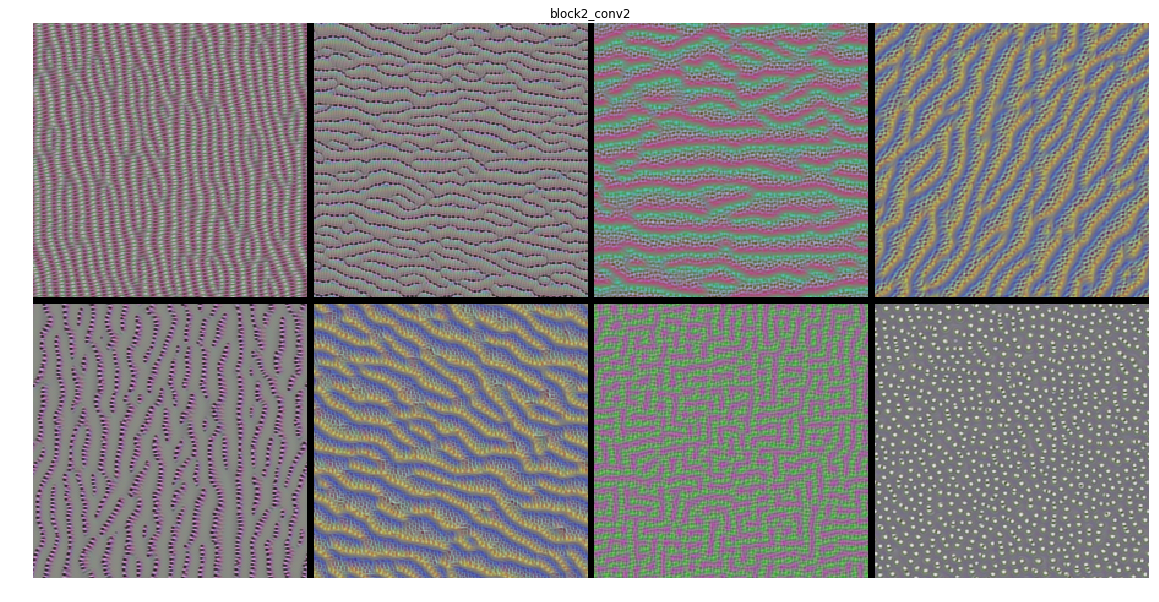

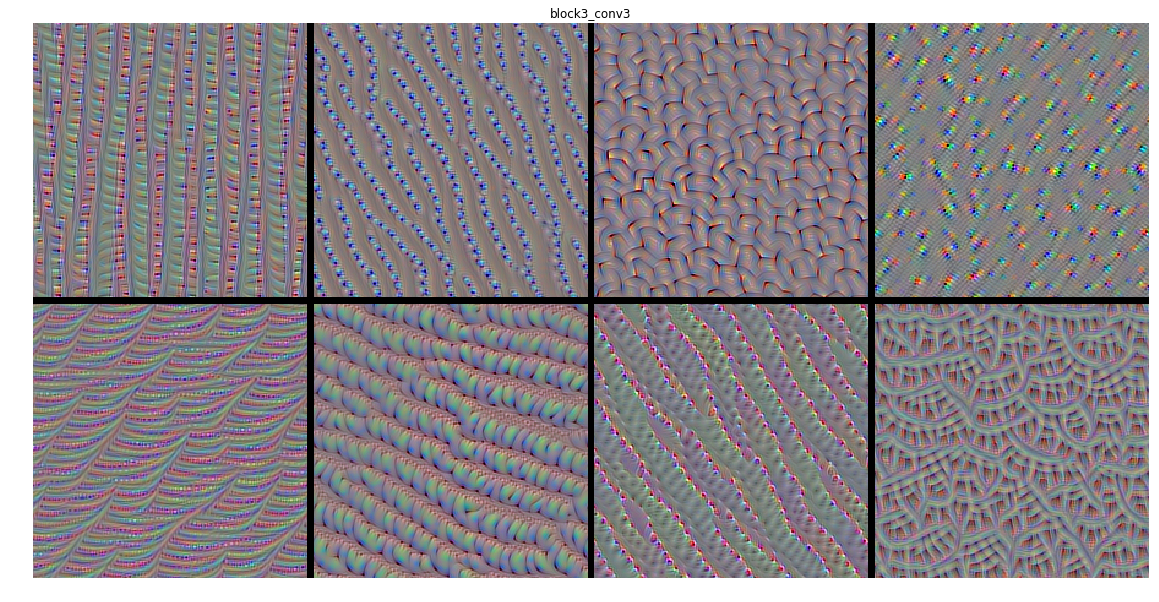

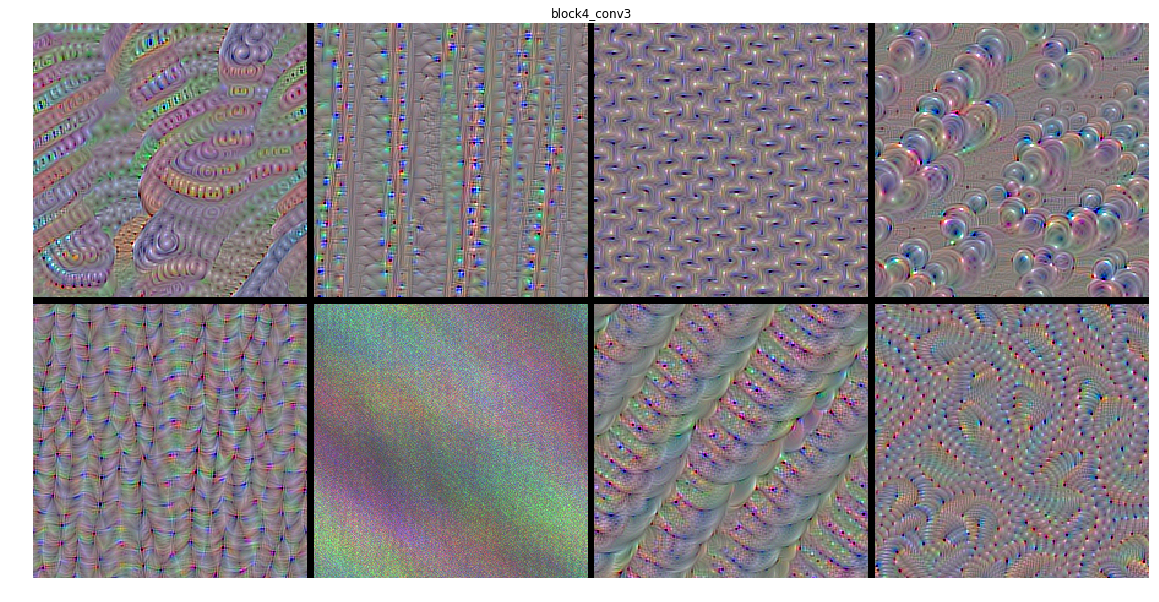

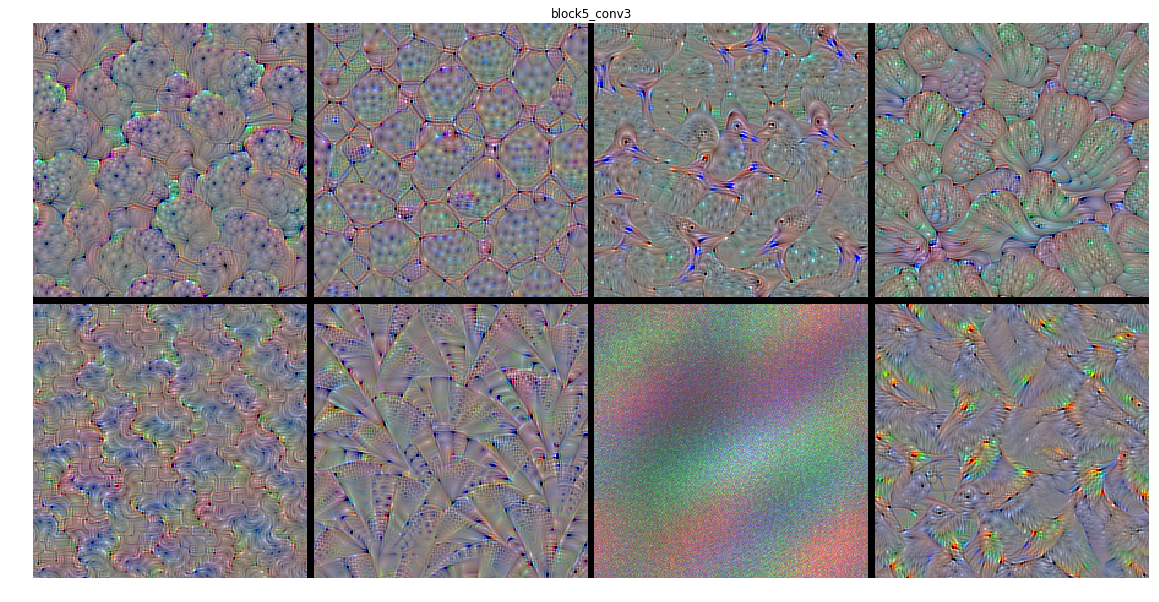

In [10]:
max_filters = 40
selected_indices = []
vis_images = [[], [], [], [], []]
i = 0
selected_filters = [[0, 3, 11, 25, 26, 33, 42, 62], 
    [8, 21, 23, 38, 39, 45, 50, 79], 
    [40, 48, 52, 54, 81, 107, 224, 226],
    [58, 79, 86, 216, 307, 426, 497, 509],
    [2, 7, 41, 84, 103, 306, 461, 487]]

for layer_name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    if selected_filters:
        filters = selected_filters[i]
    else:
        filters = sorted(np.random.permutation(get_num_filters(model.layers[layer_idx]))[:max_filters])
    selected_indices.append(filters)

    # Generate input image for each filter.
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx, tv_weight=0., 
                                   input_modifiers=[Jitter(0.05)], max_iter=300) 
        vis_images[i].append(img)

    # Generate stitched image palette with 4 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images[i], cols=4)    
    plt.figure(figsize=(20, 30))
    plt.title(layer_name)
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()
    i += 1